In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_NET = os.path.join(p,'code/multitask-nets',net)
sys.path.insert(0, PATH_NET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, FixedPoint_Model
import tools
from tools_lnd import generate_Beta_epoch, get_T_inds, add_ax_labels, TDR_axes, eigenspectrum_axes, out_axes
from tools_lnd import make_h_trial_rule, comp_eig_decomp, plot_FP, get_model_params, take_names, name_best_ckpt
from tools_lnd import plot_epoch_dynamics, make_fp_struct, make_fp_tdr_fig, make_h_trial_rule, get_D

In [2]:
rule = 'delaygo'
model_n = 0
if net is 'stepnet':
    dir_specific_all = net+'/crystals/softplus/l2w0001'#'crystals/softplus/l2h00001'#'crystals/softplus/no_reg'#s'crystals/softplus/l2h00001'#'tepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
elif net is 'highd_inputs':
    dir_specific_all = 'crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
elif net is 'armnet':
    dir_specific_all = 'lowD/armnet_noreg/most/'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
m = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
ckpt_n = name_best_ckpt(m,rule)
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))

task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

tab20 = plt.get_cmap('tab20')
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
color_inds = (tab20c(8/20),tab20c(9/20),tab20c(10/20),tab20c(4/20),tab20c(5/20),tab20c(6/20),
             tab20b(0/20),tab20b(12/20),tab20b(1/20),tab20b(13/20),tab20b(16/20),
             tab20b(2/20),tab20b(14/20),tab20b(3/20),tab20b(15/20),tab20b(17/20),
             tab20(18/20),tab20(19/20),tab20(16/20),tab20(17/20))
    
model = Model(m)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule, hparams, mode = 'random', batch_size = 100, noise_on=True, delay_fac =1)   

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/ckpts/model.ckpt-179000


In [3]:
def make_longfix_h_trial_rule(model_dir_all,mode = 'random',noise_on = False):
    
    trial = {}
    h = {}
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.restore()#model.saver.restore(sess,ckpt_n_dir)
        model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hp = model.hp

        for rule in hp['rule_trains']:
            trial[rule] = generate_trials(rule, hp, mode,
                            batch_size=400, delay_fac=hp['delay_fac'],noise_on = False)
            
            trial[rule].x = np.repeat(trial[rule].x[:1,:,:],500,axis = 0)

            # Generating feed_dict.
            feed_dict = tools.gen_feed_dict(model, trial[rule], hp)
            h[rule] = sess.run(model.h, feed_dict=feed_dict)
            
    return h, trial, hp['rule_trains']

In [4]:
#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'

h,trial,tasks = make_h_trial_rule(m,noise_on = False)
w_in, b_in, w_out, b_out = get_model_params(m)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [5]:
h_combined = []

task_list_short = ['fdgo', 'delaygo', 'fdanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

for rule in task_list:
    T_inds = get_T_inds(trial[rule],'fix1')
    trial_set = npr.permutation(np.shape(h[rule])[1])[:80]
    h_temp = h[rule][T_inds[1]-1,trial_set,:]

    #concatenate activity states across tasks
    if len(h_combined)==0:
        h_combined = h_temp
    else:
        h_combined = np.concatenate((h_combined, h_temp), axis=0)

In [6]:
h_combined = []

task_list_short = ['fdgo', 'delaygo', 'fdanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

for rule in ['fdgo', 'fdanti']:
    T_inds = get_T_inds(trial[rule],'fix1')
    trial_set = npr.permutation(np.shape(h[rule])[1])[:80]
    h_temp = h[rule][T_inds[1]-1,trial_set,:]

    #concatenate activity states across tasks
    if len(h_combined)==0:
        h_combined = h_temp
    else:
        h_combined = np.concatenate((h_combined, h_temp), axis=0)

In [6]:
pca = PCA(n_components = 4)
_ = pca.fit_transform(h_combined)
D_use = pca.components_[:2,:].T

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/fdgo/fix1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/reactgo/fix1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaygo/fix1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/fdanti/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/reactanti/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepne

/Users/lauradriscoll/Documents/code/multitask-nets/stepnet/tools_lnd.py:981: RuntimeWarning: divide by zero encountered in log10
  fp_num = np.argmin(np.log10(fp_struct['qstar']))


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaydm1/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaydm2/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/contextdelaydm1/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/contextdelaydm2/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/multidelaydm/fix1_180.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmsgo/fix1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmsnogo/fix1_180.0.npz


IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmcgo/fix1_0.0.npz'

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


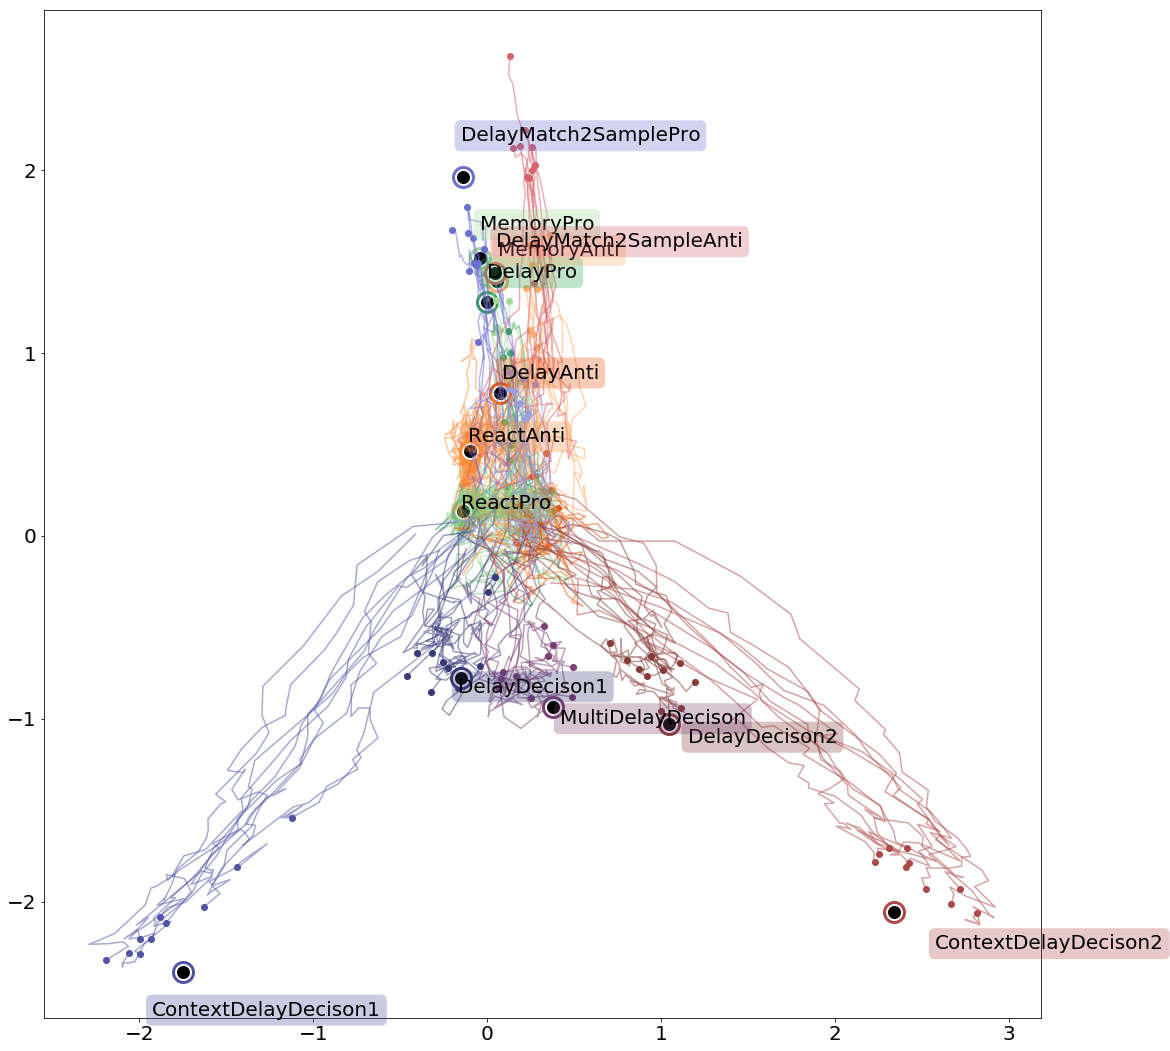

In [7]:
plt.rcParams.update({'font.size': 20})
epoch = 'fix1'
stim_ind = 0

for ri_master in range(len(task_list)):
    rule_master = task_list[ri_master]

    h,trial,tasks = make_h_trial_rule(m, mode = 'test', noise_on = True)
    lim = []

    nc = 1
    nr = 1
    fig = plt.figure(figsize=(15*nc,15*nr),tight_layout=True,facecolor='white')
    ax = plt.subplot(nr,nc,1)

    for ri in range(len(task_list)):
        rule = task_list[ri]
        
        T_inds = get_T_inds(trial[rule],'fix1')
        trial_set = npr.permutation(np.shape(h[rule])[1])[:10]
        for t in trial_set:
            h_temp = h[rule][T_inds,t,:]
            h_D = np.dot(h_temp,D_use)
            plt.plot(h_D[:,0],h_D[:,1],c = color_inds[ri],alpha = .5)
            plt.plot(h_D[-1,0],h_D[-1,1],'o',c = color_inds[ri])
                
        if rule.find('go')>=0:
            adjust_stim = 0
        else:
            adjust_stim = 180

        if rule.find('nogo')>=0:
            adjust_stim = 180

        fps, _ = make_fp_struct(m,fp_file,rule,epoch,adjust_stim)
        fps_tdr = np.dot(fps,D_use)
        plt.plot(fps_tdr[:,0],fps_tdr[:,1],'o',markeredgecolor = color_inds[ri],
                 markerfacecolor = 'w',markersize=20,markeredgewidth=3)
        plt.plot(fps_tdr[:,0],fps_tdr[:,1],'ok',markersize=10,markeredgewidth=3)
        _, rule_name, _ , _ = take_names(epoch,rule)
        plt.text(fps_tdr[:,0]*1.1,fps_tdr[:,1]*1.1, rule_name, color = 'k',
                bbox=dict(facecolor=color_inds[ri], edgecolor='none', boxstyle='round', alpha = .3))

#     ax = plot_epoch_dynamics(fig,m,fp_file,epoch,h,trial,rule_master,D_use,[adjust_stim,],lim = lim,
#                              stim_loc_fp = adjust_stim, ax_type = 'pca', plot_eigenspect = False)

#     figpath = os.path.join(m,'Dynamics Figures')
#     figname = rule_master + '_' + epoch +'.pdf'
#     if not os.path.exists(figpath):
#         os.makedirs(figpath)
#     plt.savefig(os.path.join(figpath,figname))

#     plt.subplots_adjust(bottom=0.3, right=.9, top=0.9,wspace = 0,hspace = 0)
#     figname = rule_master + '_' + epoch +'.png'
#     plt.savefig(os.path.join(figpath,figname))

    plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/fdgo/fix1_0.0.npz


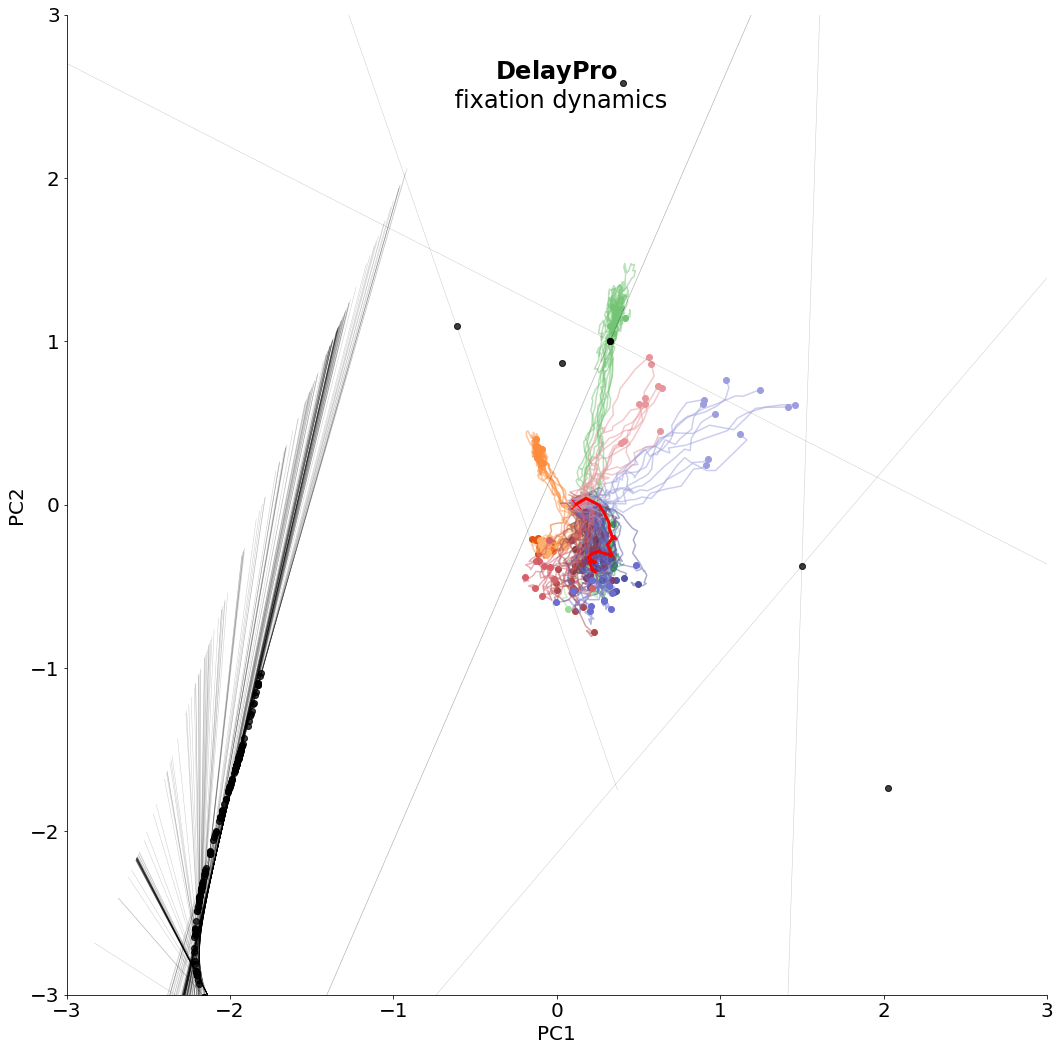

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/reactgo/fix1_0.0.npz


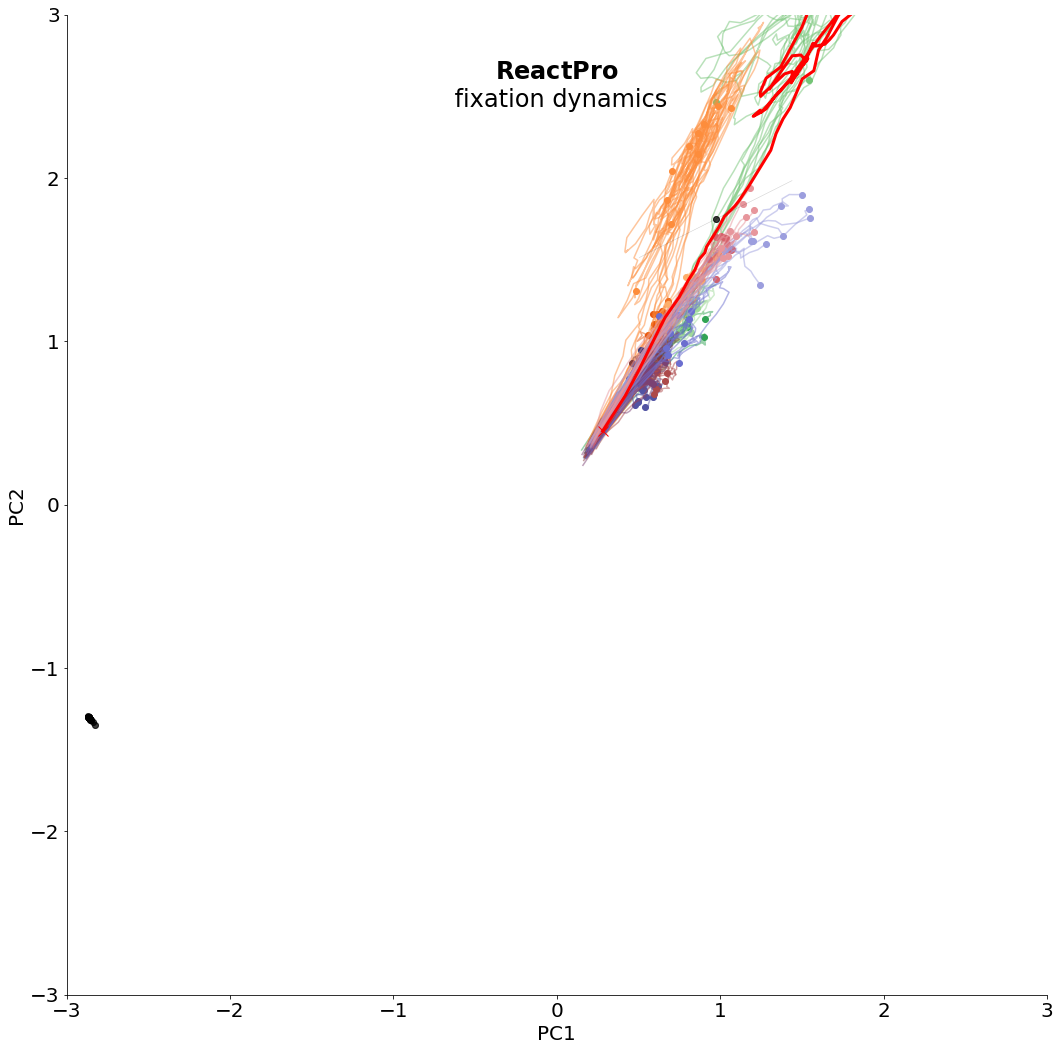

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaygo/fix1_0.0.npz


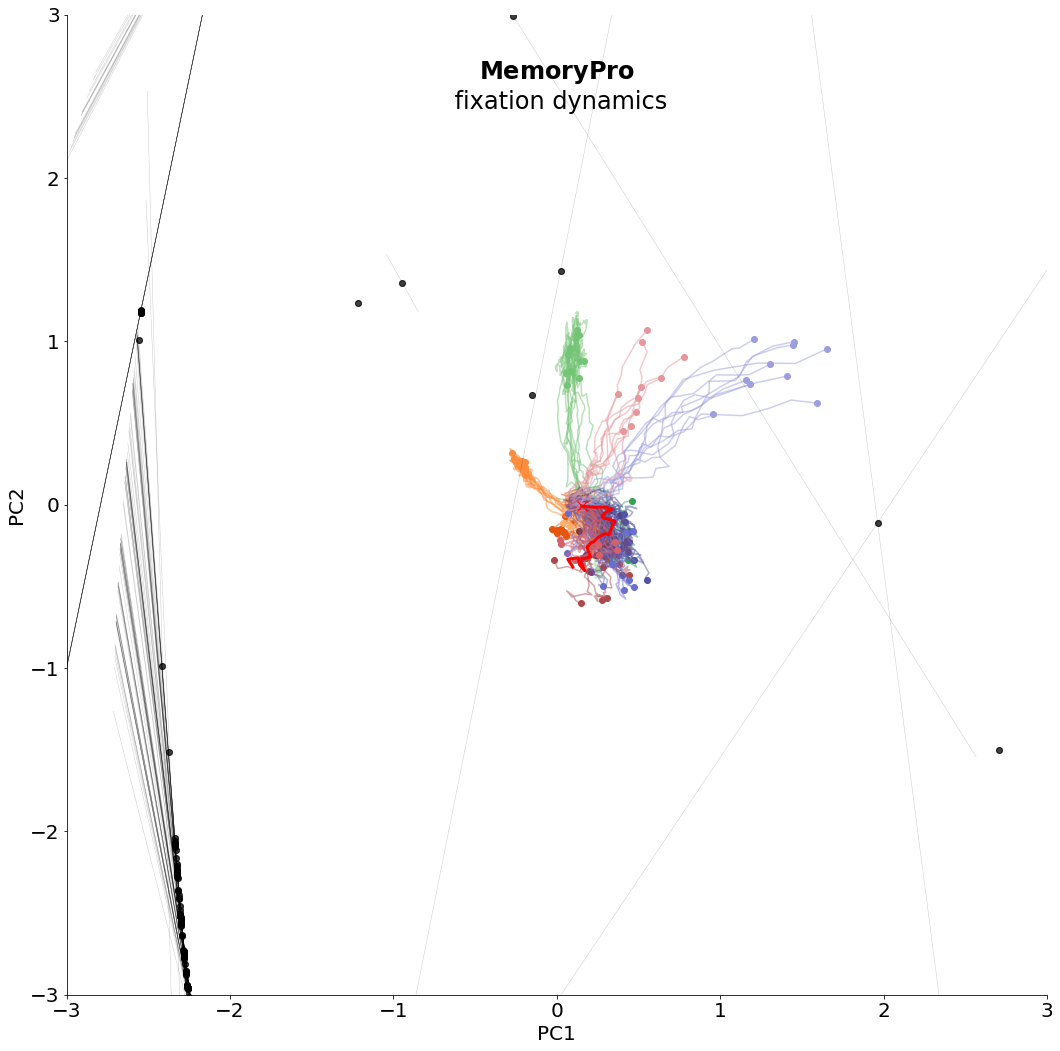

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/fdanti/fix1_180.0.npz


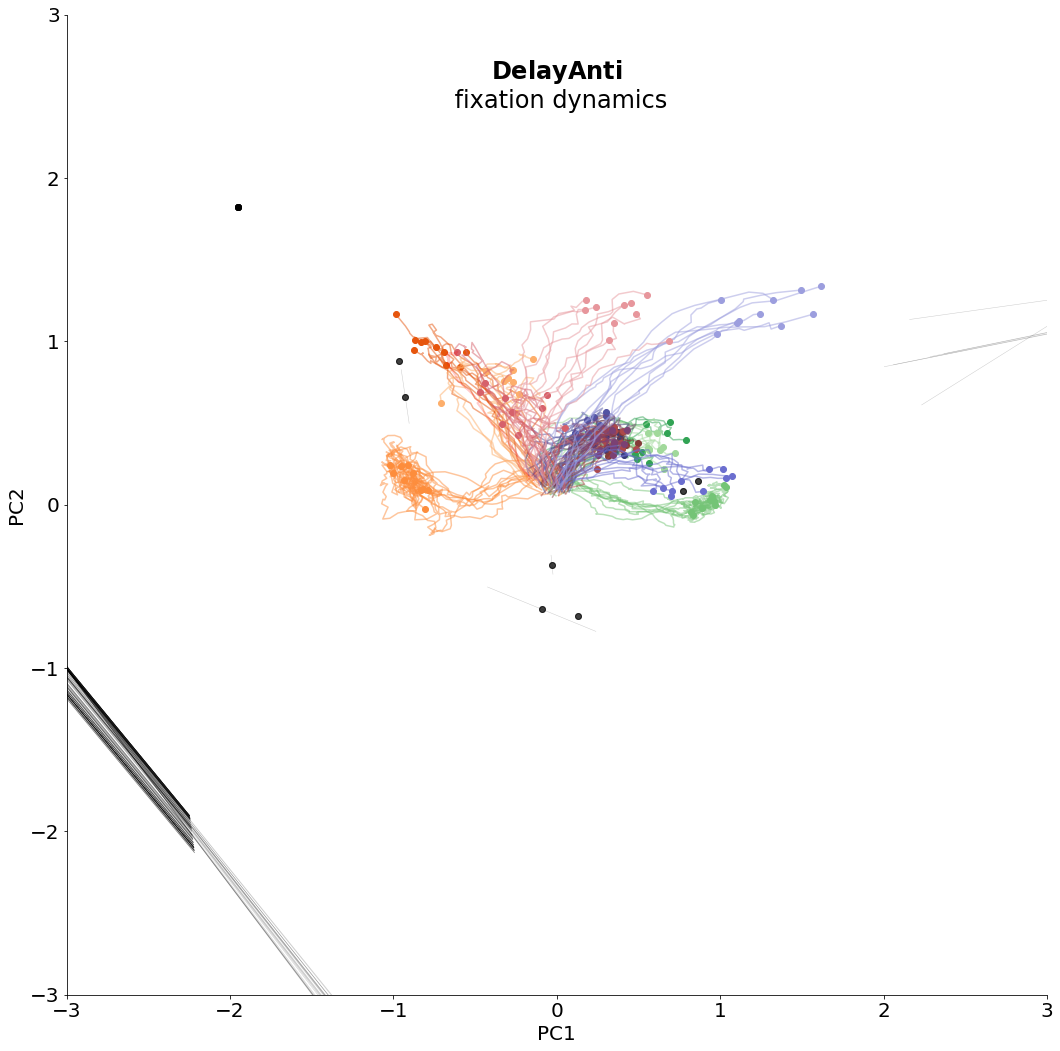

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/reactanti/fix1_180.0.npz


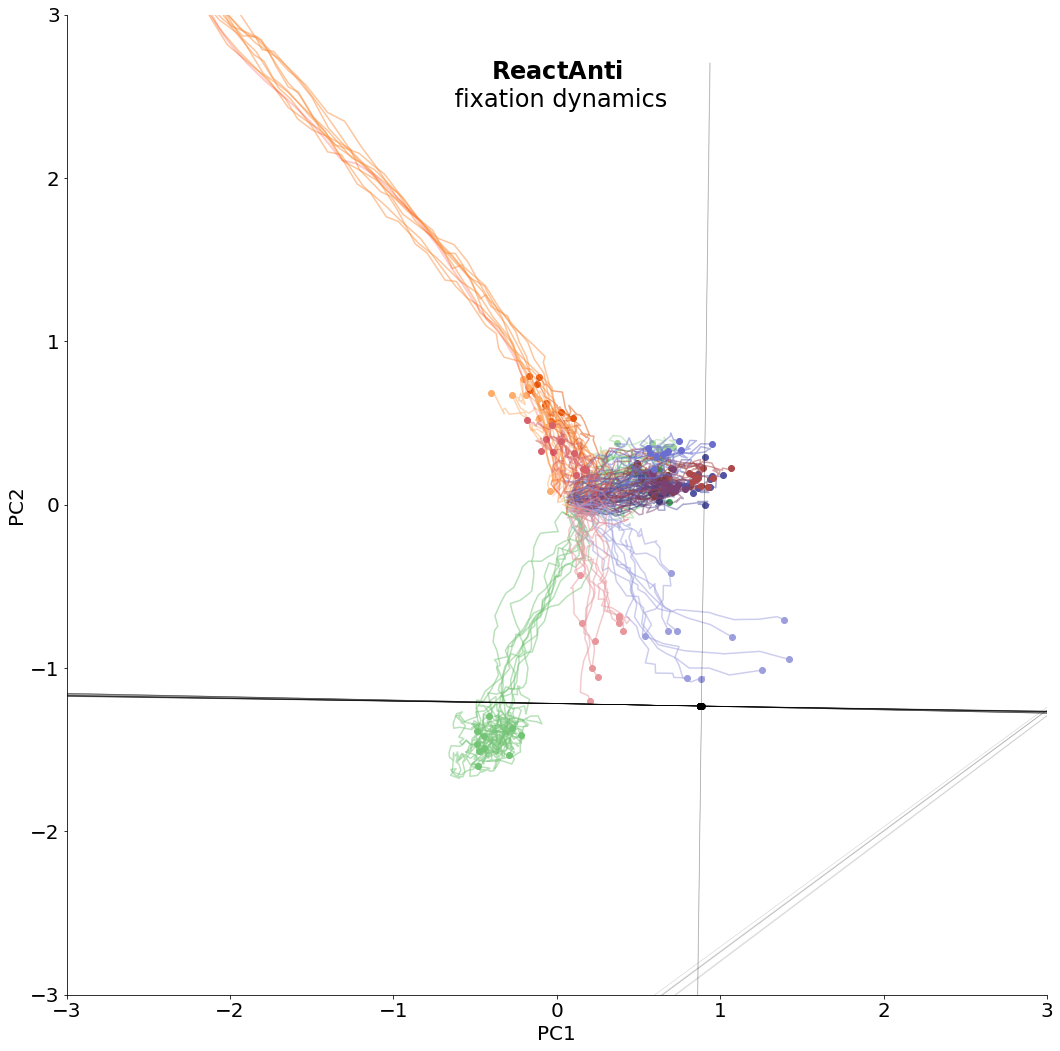

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delayanti/fix1_180.0.npz


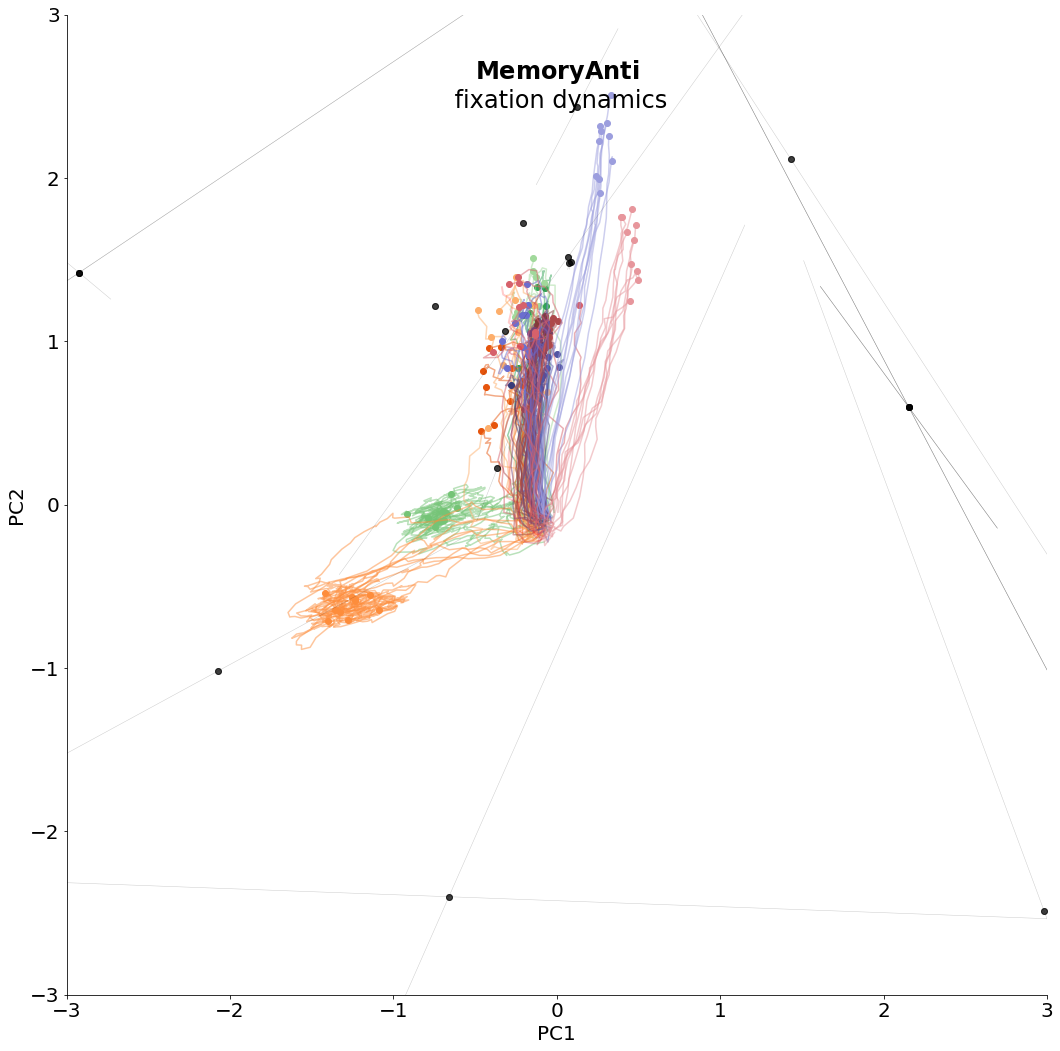

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaydm1/fix1_180.0.npz


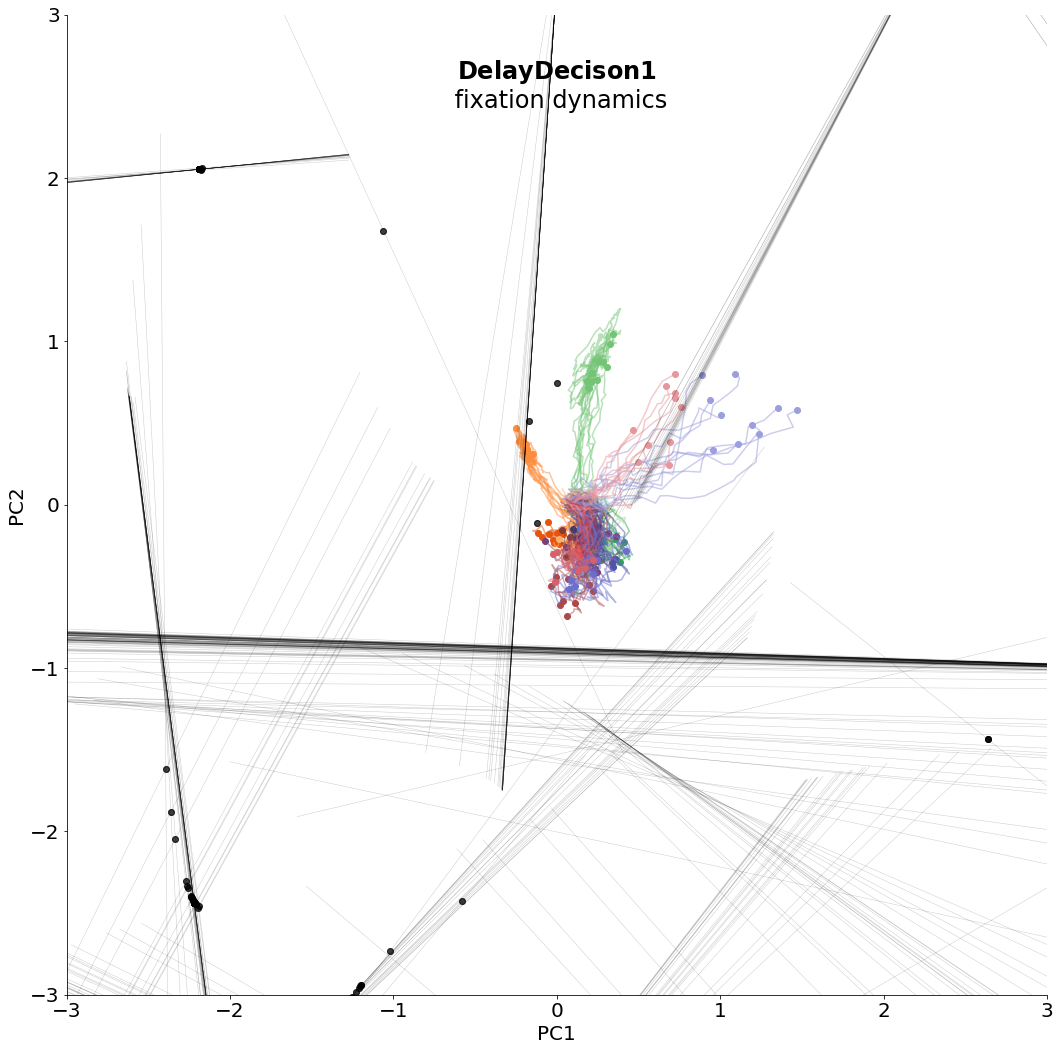

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/delaydm2/fix1_180.0.npz


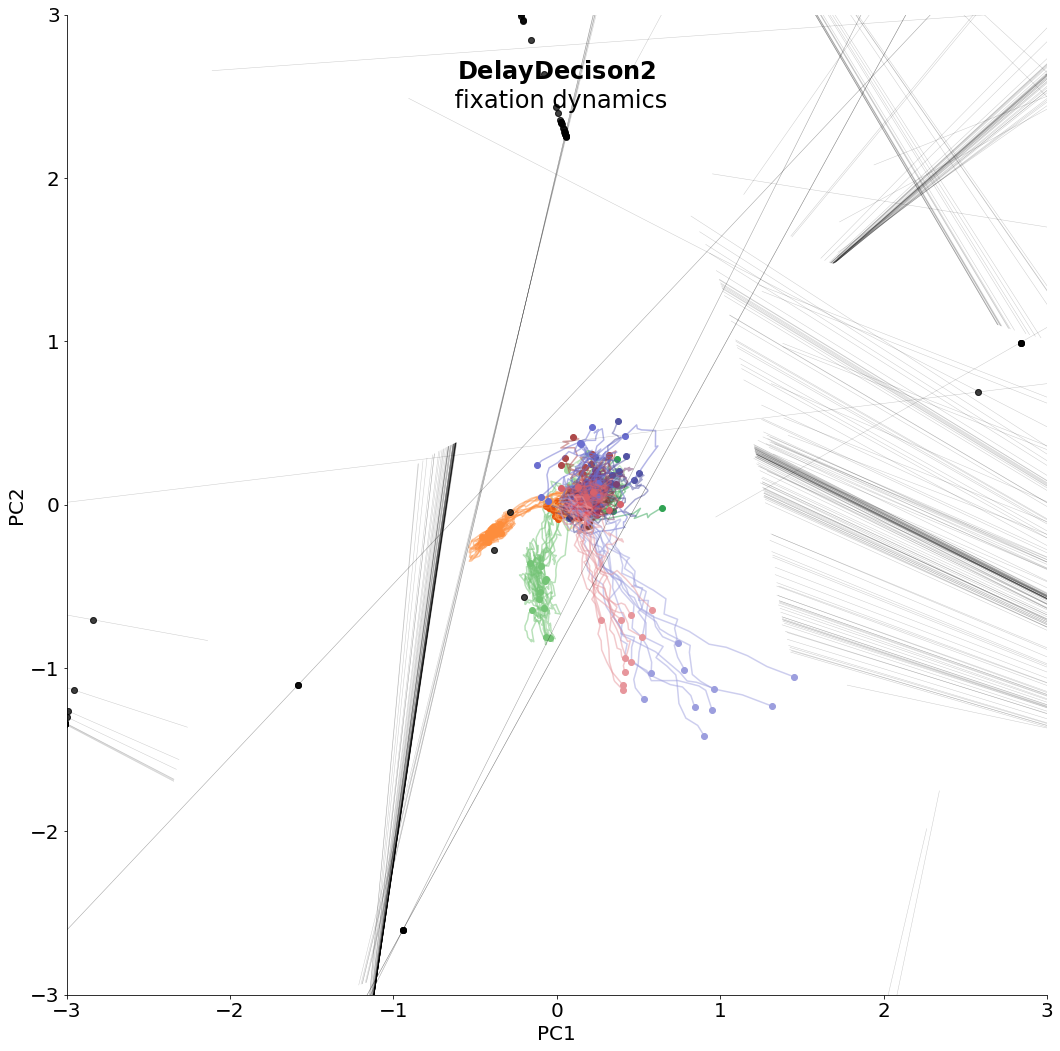

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/contextdelaydm1/fix1_180.0.npz


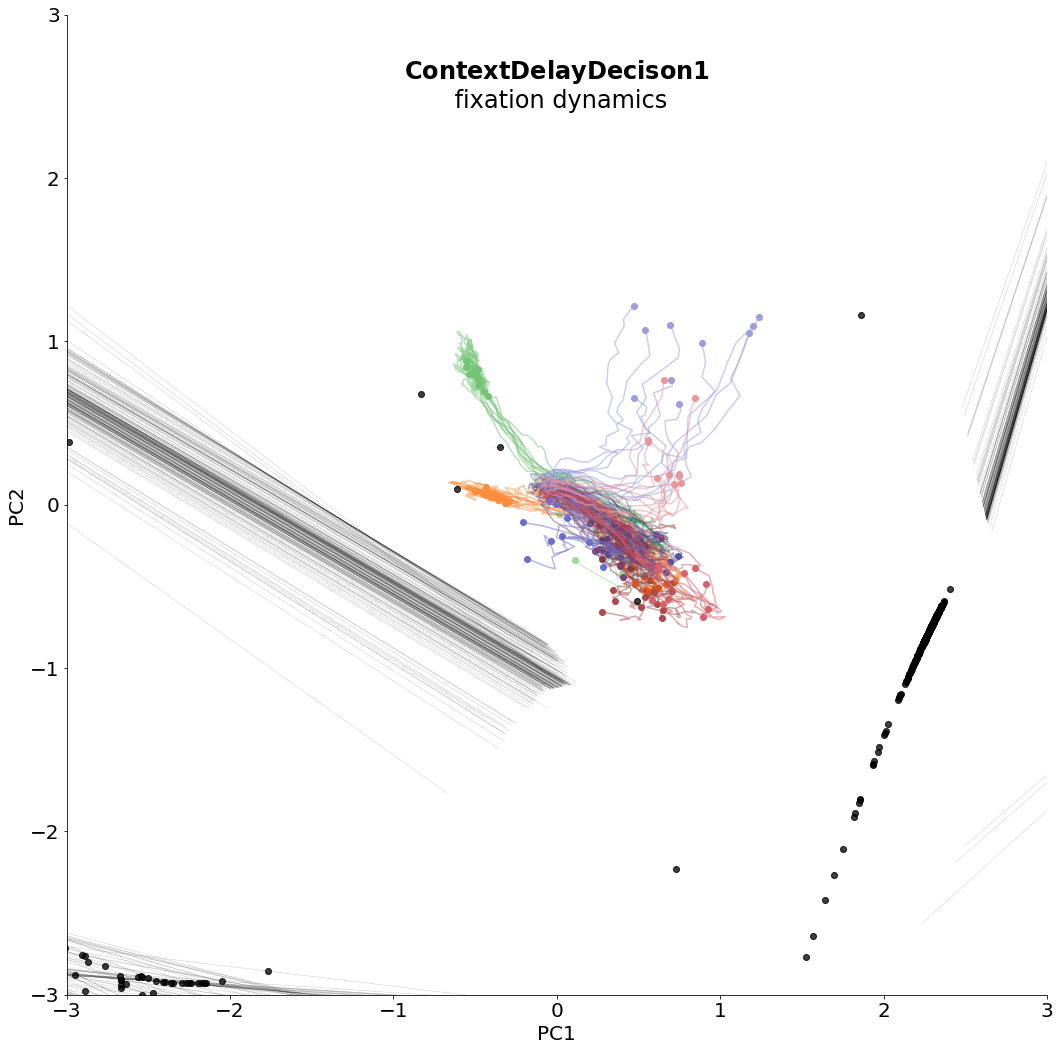

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/contextdelaydm2/fix1_180.0.npz


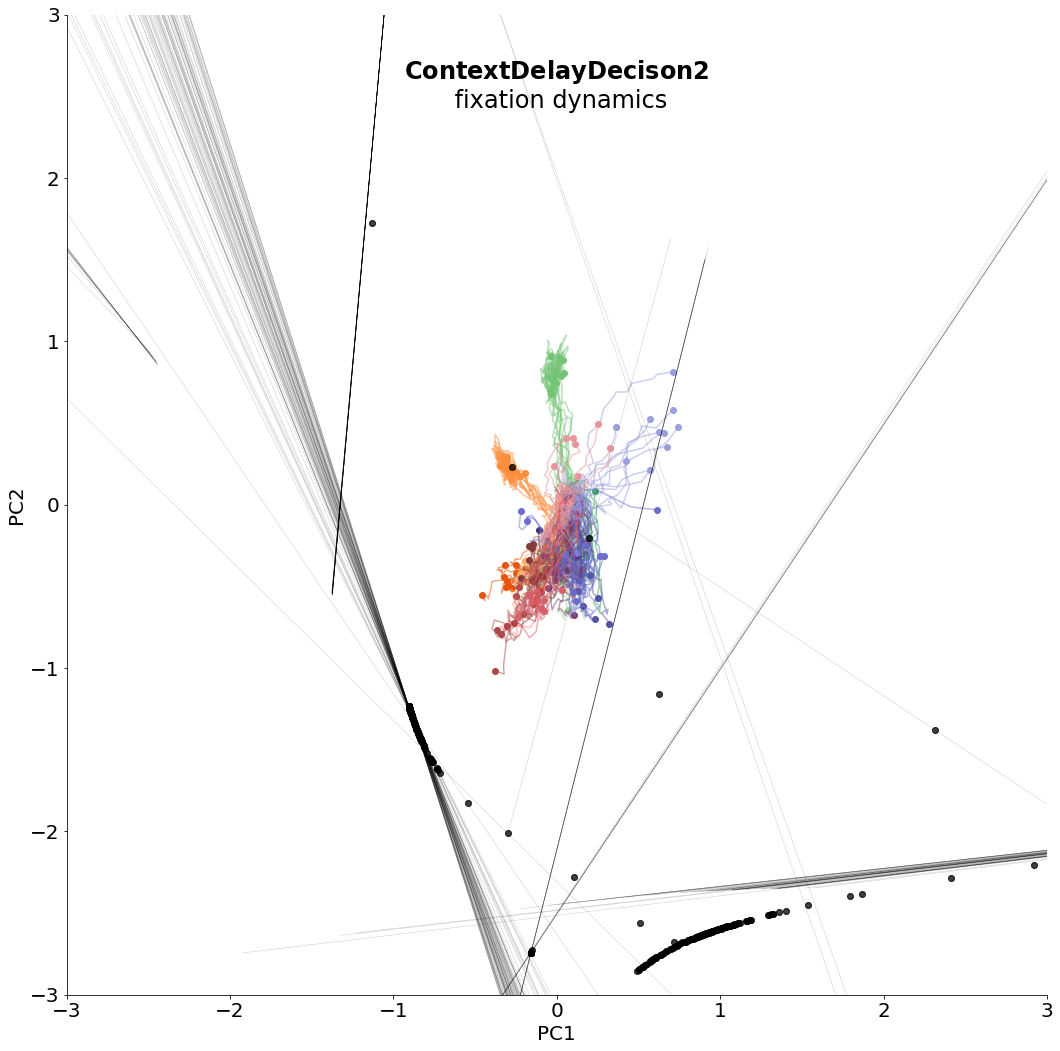

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/multidelaydm/fix1_180.0.npz


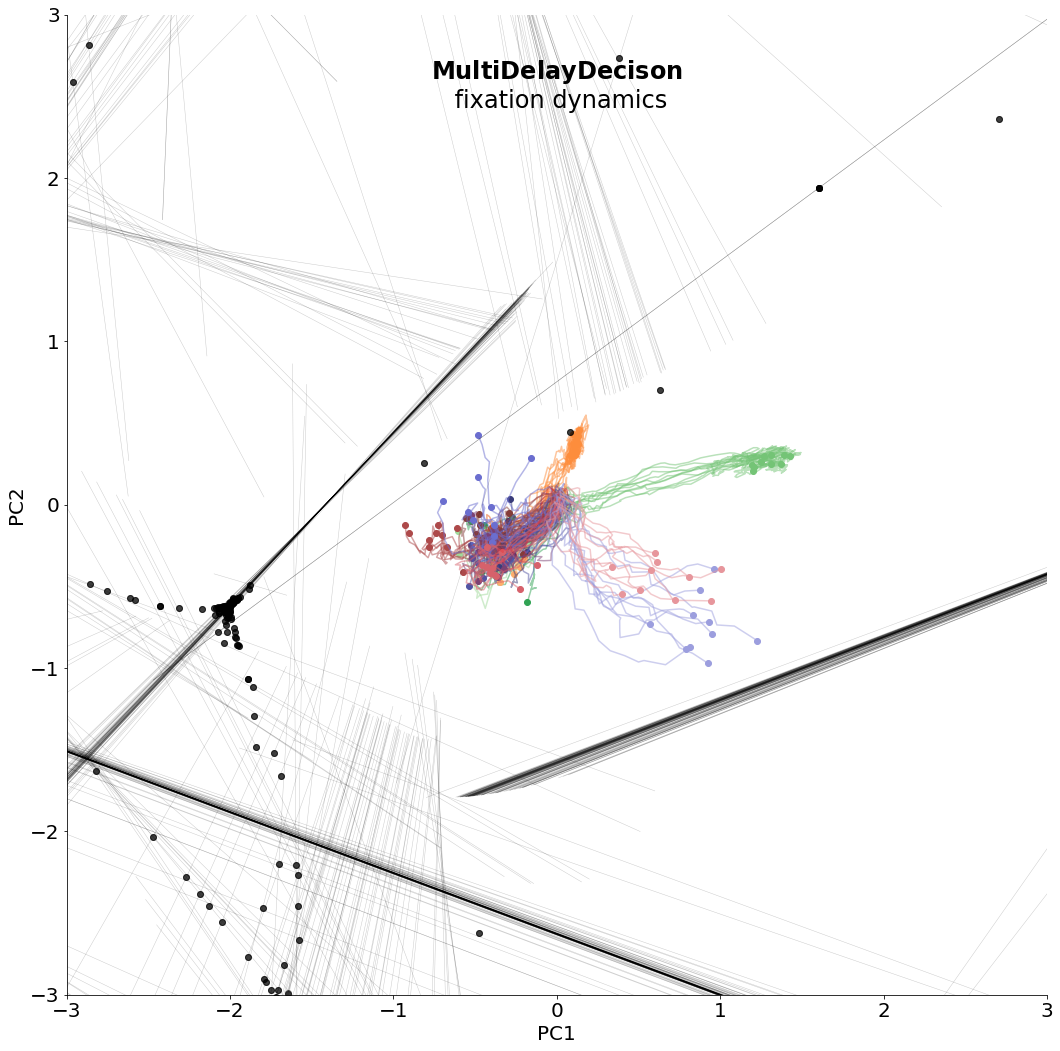

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmsgo/fix1_0.0.npz


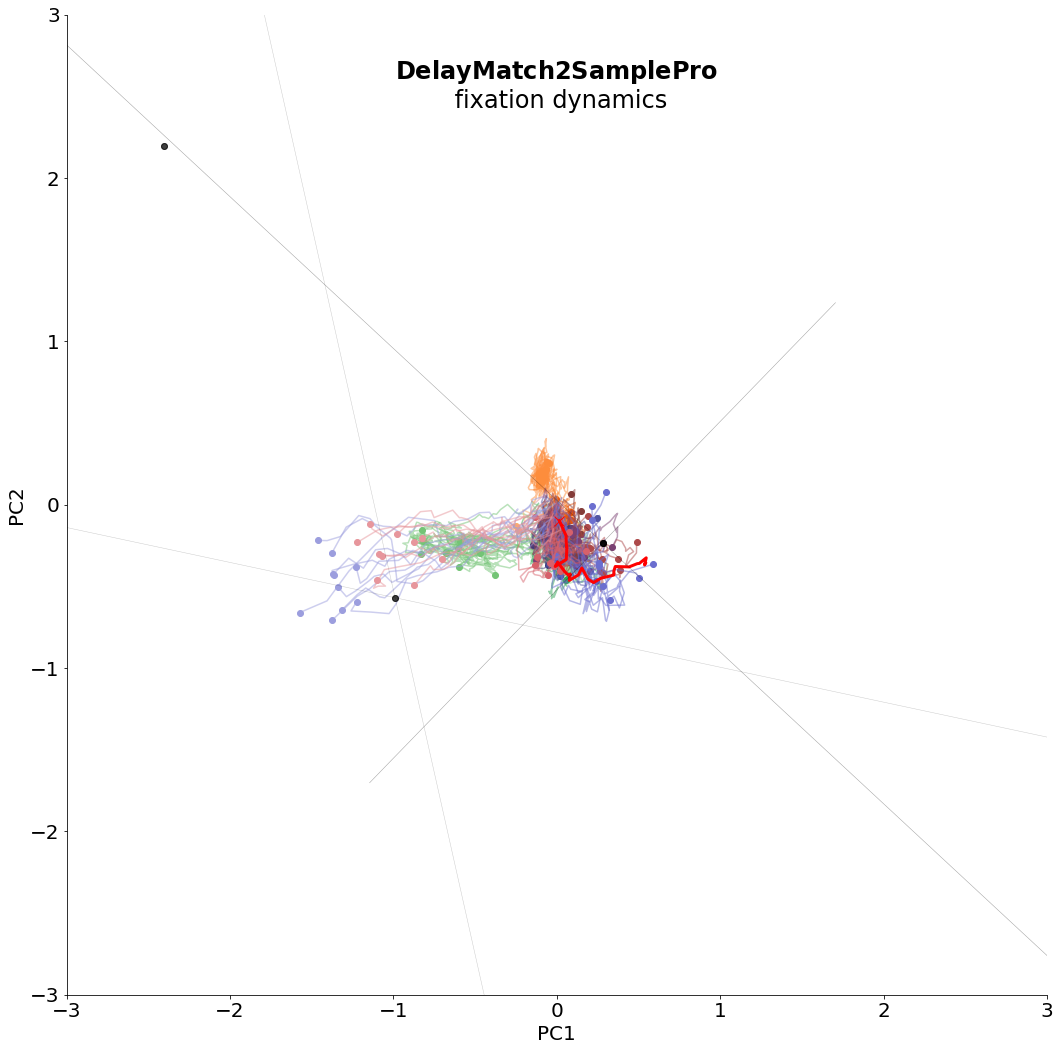

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmsnogo/fix1_180.0.npz


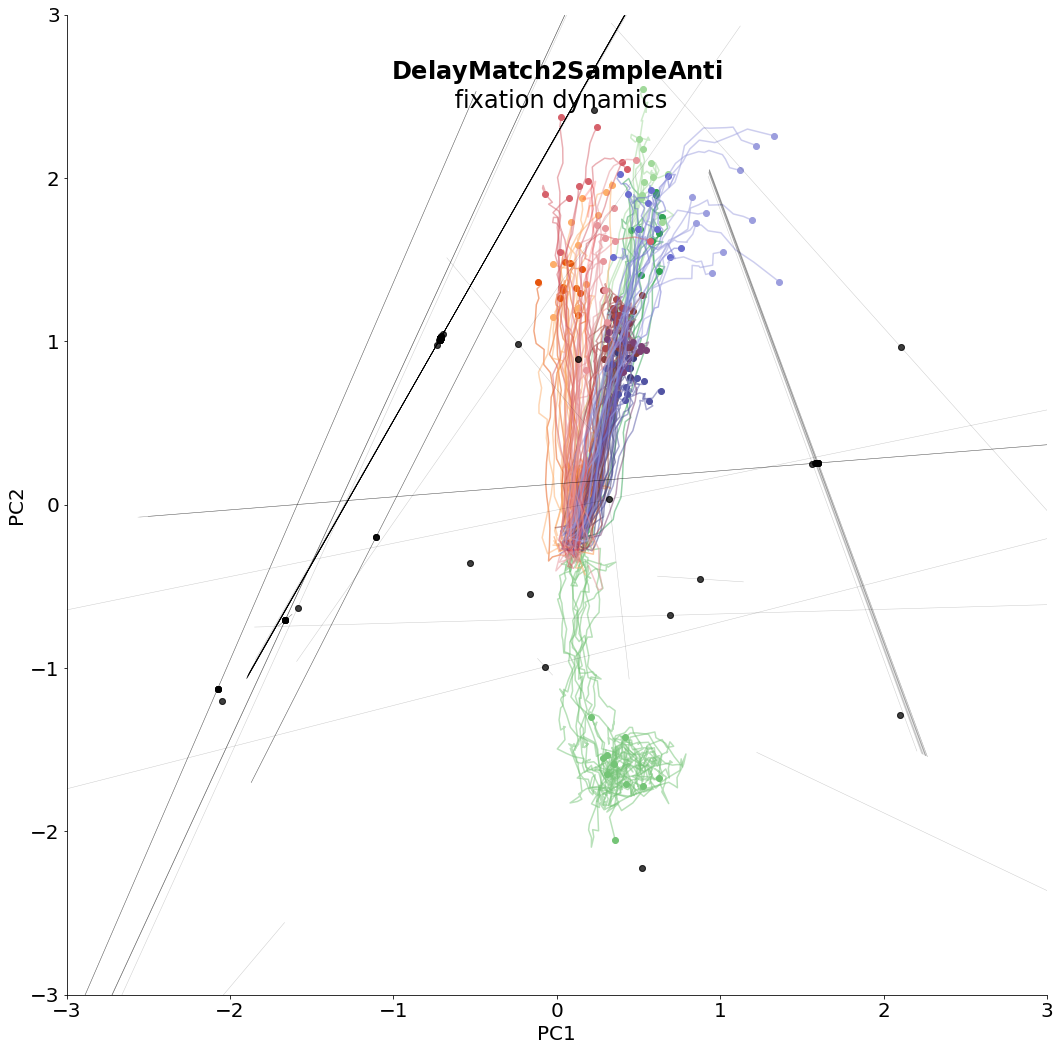

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/tf_fixed_pts_all_init/dmcgo/fix1_0.0.npz'

In [10]:
plt.rcParams.update({'font.size': 20})
epoch = 'fix1'
stim_ind = 0

for ri_master in range(len(task_list)):
    rule_master = task_list[ri_master]
    
    if rule_master.find('go')>=0:
        adjust_stim = 0
    else:
        adjust_stim = 180

    if rule_master.find('nogo')>=0:
        adjust_stim = 180
    
    filename = os.path.join(m,fp_file,rule_master,epoch+'_'+str(round(adjust_stim,2))+'.npz')
    fp_struct = np.load(filename)
    X = fp_struct['xstar']

    pca = PCA(n_components = 4)
    _ = pca.fit_transform(X)
    D_use = pca.components_[:2,:].T

    h,trial,tasks = make_h_trial_rule(m, mode = 'test', noise_on = True)
    lim = []

    nc = 1
    nr = 1
    fig = plt.figure(figsize=(15*nc,15*nr),tight_layout=True,facecolor='white')
    ax = plt.subplot(nr,nc,1)

    for ri in range(len(task_list)):
        rule = task_list[ri]
        
        T_inds = get_T_inds(trial[rule],'fix1')
        trial_set = npr.permutation(np.shape(h[rule])[1])[:10]
        for t in trial_set:
            h_temp = h[rule][T_inds,t,:]
            h_D = np.dot(h_temp,D_use)
            plt.plot(h_D[:,0],h_D[:,1],c = color_inds[ri],alpha = .5)
            plt.plot(h_D[-1,0],h_D[-1,1],'o',c = color_inds[ri])

    ax = plot_epoch_dynamics(fig,m,fp_file,epoch,h,trial,rule_master,D_use,[adjust_stim,],lim = lim,
                             stim_loc_fp = adjust_stim, ax_type = 'pca', plot_eigenspect = False)
    
    plt.xlim(-3,3)
    plt.ylim(-3,3)

    plt.show()

In [111]:
epochs = ['fix1','stim1','delay1','go1']
epoch_names = ['fixation','stimulus','memory','go']
ei = [i for i,e in enumerate(epochs) if e==epoch]
epoch_name = epoch_names[ei[0]]

In [69]:
rule = 'fdanti'
epoch = 'stim1'
# h,trial,tasks = make_h_trial_rule(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[epoch]
lim = 8.5
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = lim)

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

IndexError: list index out of range

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/fdanti/go1_180.0.npz


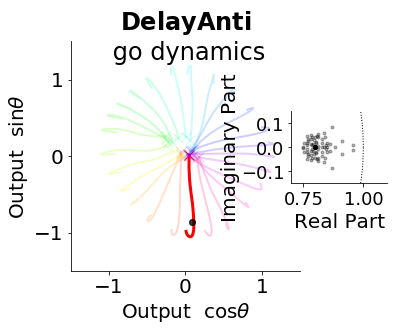

In [4]:
rule = 'fdanti'
epoch = 'go1'
w_in, b_in, w_out, b_out = get_model_params(m)
D_use = w_out[:,1:]
lim = 2
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = 1.5,ax_type = 'out')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/delayanti/stim1_180.0.npz


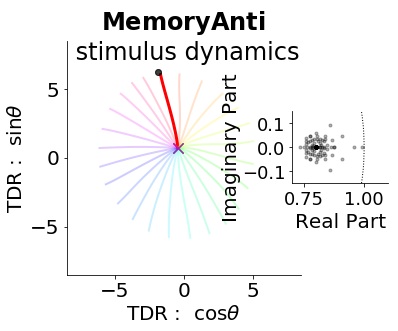

In [5]:
rule = 'delayanti'
epoch = 'stim1'
# h,trial,tasks = make_h_trial_rule(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[epoch]
lim = 8.5
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = lim)

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/delayanti/delay1_180.0.npz


/Users/lauradriscoll/Documents/code/sequential_multiTask_RNN/tools_lnd.py:697: RuntimeWarning: divide by zero encountered in log10
  fp_num = np.squeeze(np.argwhere(np.log10(fp_struct['qstar'])<-0))


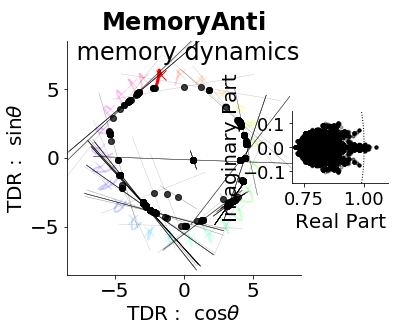

In [6]:
rule = 'delayanti'
epoch = 'delay1'
axes_epoch = 'stim1'
ax_type= 'tdr'
# h,trial,tasks = make_h_trial_rule(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = -1)
D_use = B[axes_epoch]
lim = 8.5
ax = plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],lim = lim,epoch_axes = axes_epoch)

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/delayanti/go1_180.0.npz


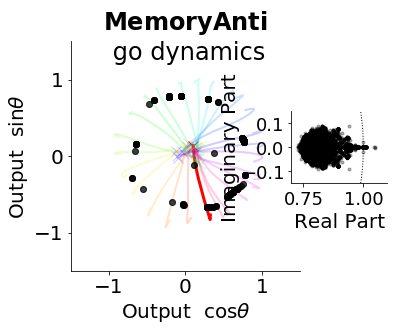

In [7]:
rule = 'delayanti'
epoch = 'go1'
w_in, b_in, w_out, b_out = get_model_params(m)
D_use = w_out[:,1:]
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,[stim_theta,],ax_type = 'out')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/delayanti/delay1_180.0.npz


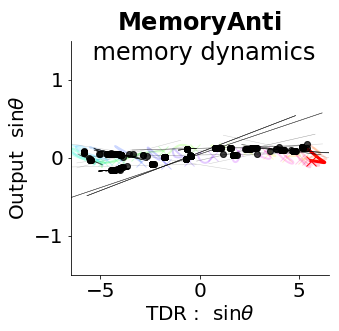

In [8]:
rule = 'delayanti'
epoch = 'delay1'
epoch_axes = 'go1'
ax_type = 'mix'
w_in, b_in, w_out, b_out = get_model_params(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = 0)
D_use = np.concatenate((B[epoch_axes][:,1][:,np.newaxis],w_out[:,2][:,np.newaxis]),axis = 1)
lim = 6.5
ax = plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,y_set = [stim_theta,],plot_eigenspect = False, lim = lim,
                    ax_type = 'mix',epoch_axes = 'stim1')
# ax.set_aspect('equal')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/sequential_multiTask_RNN/trained_nets_lea/sequential_tasks/ours/goantiset/a/2/tf_fixed_pts_all_init/delayanti/go1_180.0.npz


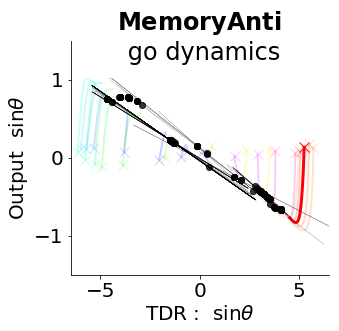

In [9]:
rule = 'delayanti'
epoch = 'go1'
epoch_axes = 'go1'
ax_type = 'mix'
w_in, b_in, w_out, b_out = get_model_params(m)
B = generate_Beta_epoch(h[rule],trial[rule],ind = 0)
D_use = np.concatenate((B[epoch_axes][:,1][:,np.newaxis],w_out[:,2][:,np.newaxis]),axis = 1)
plot_epoch_dynamics(m,fp_file,epoch,h,trial,rule,D_use,y_set = [stim_theta,],plot_eigenspect = False, lim = 6.5,
                    ax_type = 'mix',epoch_axes = 'stim1')

figpath = os.path.join(m,'Dynamics Figures')
figname = rule + '_' + epoch + '_' + ax_type +'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))

plt.subplots_adjust(bottom=0.3, right=.9, top=0.9)
figname = rule + '_' + epoch + '_' + ax_type +'.png'
plt.savefig(os.path.join(figpath,figname))

plt.show()